<a href="https://colab.research.google.com/github/natehorner/learn_pt_02/blob/main/pt_vision_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#install - once only

!pip install torchmetrics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.4 MB/s eta 0:00:00


In [59]:
#common block - run once to prevent re-dwnload as debugging
import torch
from torch import nn
SEED_BASE = int("BADBEEF",16)
device = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


if(device == "cpu"):
  torch.manual_seed(SEED_BASE)
else:torch.cuda.manual_seed(SEED_BASE)

import torchmetrics
from torchmetrics import Accuracy

print(torch.__version__)
print(torchvision.__version__)


"""
from: https://pytorch.org/vision/stable/datasets.html

imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)
"""


train_data = datasets.FashionMNIST(
    root="data",#destination directory
    train=True, #training, not test
    download=True, #download yes
    transform=ToTensor(), #how output should be handled
    target_transform=None #how lables/targets should be handled
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


2.1.0+cu118
0.16.0+cu118


In [20]:
#debug - understand whats going on with training data

#len(train_data),len(test_data)
#: (60000, 10000)

class_names = train_data.classes
#class_names
#: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
#:  'Sneaker', 'Bag', 'Ankle boot']

train_data.targets
#: tensor([9, 0, 0,  ..., 3, 0, 5])

train_data.targets
train_data.data #densor of all 6000 x 28 x 28 images


#image,label = train_data[0]

#image.shape
#: torch.Size([1, 28, 28])

#label
#: 9

#class_names = train_data.classes #...from above...
#class_names[label]
#: 'Ankle boot


'Ankle boot'

Text(0.5, 1.0, 'Ankle boot')

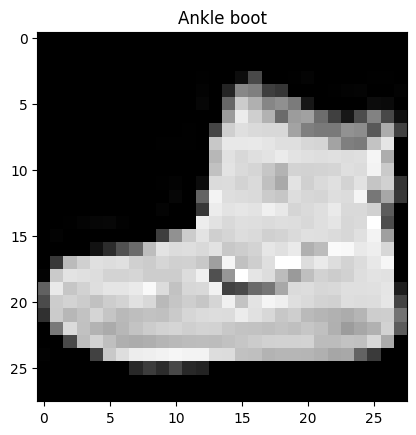

In [26]:
#debug - visualize the image data...

class_names = train_data.classes
image,label = train_data[0]
#image.shape
#: torch.Size([1, 28, 28])

plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])




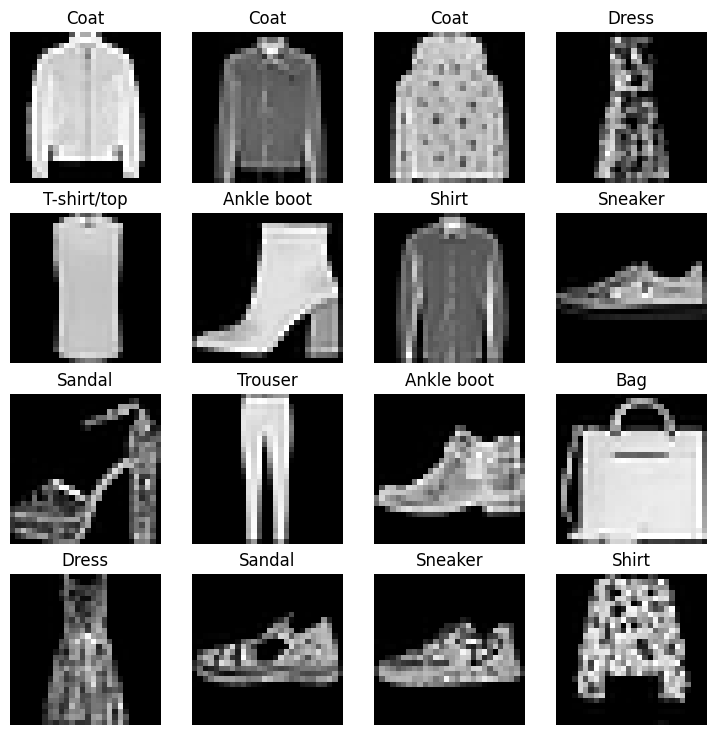

In [35]:
#plot 9 random images - seed is set above so it will change on re-run
class_names = train_data.classes
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)



In [39]:


#break this down to batches of 32 each
BATCH_SIZE = 32

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #shuffle makes it so that ordered
                                            # data sets don't matter



test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

#print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} total {len(train_data)}")
#print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} total {len(test_data)}")
#: Length of train_dataloader: 1875 batches of 32 total 60000
#: Length of test_dataloader: 313 batches of 32 total 10000



Length of train_dataloader: 1875 batches of 32 total 60000
Length of test_dataloader: 313 batches of 32 total 10000


In [61]:

#start making a model!
IN_FEAT = 28*28
HIDDEN_UNITS = 10
OUT_CLASSES = len(class_names)
LEARN_RATE = 0.05
EPOCHS = 10000 #batches of 32?

class FashionMNISTModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),#flatten the 28x28 input to a vector
      nn.Linear(in_features=input_shape,
                out_features=hidden_units),
      nn.Linear(in_features=hidden_units,
                out_features=output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

torch.manual_seed(SEED_BASE)
model_fashion = FashionMNISTModel0(input_shape=IN_FEAT,
                                   hidden_units=HIDDEN_UNITS,
                                   output_shape=OUT_CLASSES
                                   ).to(device)



#random_x = torch.rand([1,1,28,28])
#model_fashion(random_x)
#: tensor([[-0.1270,  0.1232, -0.1482, -0.0283,  0.2149, -0.1326, -0.0536, -0.3630,
#:           0.4791, -0.0644]], grad_fn=<AddmmBackward0>)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model_fashion.parameters(),lr = LEARN_RATE)


#eval metric - use accuracy
acc_fn = Accuracy(task="MULTICLASS",num_classes=OUT_CLASSES).to(device)

"""
just pasted this and below, at 15:46:51

for epoch in range(EPOCHS):
  blob_model.train()

  y_logits = blob_model(X_blob_train)
  y_pred_label = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)

  loss_trn = loss_fn(y_logits,y_blob_train.long())
  train_acc = acc_fn(y_pred_label,y_blob_train)

  optim.zero_grad()
  loss_trn.backward()
  optim.step()
  blob_model.eval()

  #only test if we print... why would it test if it doesn't go anywhere?
  if epoch % 200 == 0 or epoch == EPOCHS-1:
    with torch.inference_mode():

      y_tst_lgt = blob_model(X_blob_test).squeeze()
      y_test_lbl = torch.argmax(torch.softmax(y_tst_lgt,dim=1),dim=1)
      loss_tst = loss_fn(y_tst_lgt,y_blob_test.long())

      test_acc = acc_fn(y_blob_test,y_test_lbl)

      print(f"Epoch: {epoch}, Train Loss: {loss_trn:.5f} Train Acc: {train_acc:.2f}%, Test Loss: {loss_tst:.5f} Test Acc: {test_acc:.2f}%")
"""